In [136]:
# RECOPILACIÓN Y CARGA DE DATOS
import pandas as pd
from pathlib import Path
import numpy as np

df_ventas = pd.read_csv('https://drive.google.com/uc?id=1ZFhhEIk4B91XDkDXfveVvkUrJ3u6mo5J&export=download')
df_clientes = pd.read_csv('https://drive.google.com/uc?id=1czywsYrIO0UYRzLO12uC26O2S_Hx8WF4&export=download')
df_marketing = pd.read_csv('https://drive.google.com/uc?id=1hJBz9eoE-ljUEC9FnFN713Oj--7GzZQq&export=download')

In [137]:
# ANÁLISIS EXPLORATORIO INICIAL de los Dataframes

def resumen(df, nombre):
    print(f"Resumen de {nombre}:")
    df.info()
    print(f"-------------------------\n")

dfs = [(df_ventas, "Ventas"), (df_clientes, "Clientes"), (df_marketing, "Marketing")]

for df, nombre in dfs:
    resumen(df, nombre)

Resumen de Ventas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035 entries, 0 to 3034
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_venta     3035 non-null   int64  
 1   producto     3035 non-null   object 
 2   precio       3033 non-null   object 
 3   cantidad     3033 non-null   float64
 4   fecha_venta  3035 non-null   object 
 5   categoria    3035 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 142.4+ KB
-------------------------

Resumen de Clientes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_cliente  567 non-null    int64  
 1   nombre      567 non-null    object 
 2   edad        567 non-null    int64  
 3   ciudad      567 non-null    object 
 4   ingresos    567 non-null    float64
dtypes: float64(1), int64(2), object

In [138]:
# NORMALIZACIÓN DE DATOS

# Ventas
df_ventas["precio"] = (df_ventas["precio"]
                        .astype(str).str.replace(r"[$,\s]", "", regex=True)
                        .replace({"nan": np.nan}).infer_objects(copy=False))   # Convierte valores faltantes en nulos reales para que pandas lo reconozca
df_ventas["precio"] = pd.to_numeric(df_ventas["precio"], errors="coerce") # convierte a numérico (float), los errores los convierte en NaN

df_ventas["fecha_venta"] = pd.to_datetime(df_ventas["fecha_venta"], dayfirst=True, errors="coerce")

# Marketing
for col in ["fecha_inicio", "fecha_fin"]:
    df_marketing[col] = pd.to_datetime(df_marketing[col], dayfirst=True, errors="coerce")

In [139]:
# CALIDAD DE DATOS

# Identificar valores nulos y duplicados en los conjuntos de datos.
precio_nulo = df_ventas["precio"].isna().sum()
cantidad_nulo = df_ventas["cantidad"].isna().sum()
print(f"Cantidad de nulos en 'precio': {precio_nulo}")
print(f"Cantidad de nulos en 'cantidad': {cantidad_nulo}")

for df, nombre in dfs:
    dups = df.duplicated().sum()
    print(f"Duplicados en {nombre}: {dups}")

Cantidad de nulos en 'precio': 2
Cantidad de nulos en 'cantidad': 2
Duplicados en Ventas: 35
Duplicados en Clientes: 0
Duplicados en Marketing: 0


In [140]:
# LIMPIEZA DE DATOS

# Eliminar duplicados
df_ventas = df_ventas.drop_duplicates().copy()

# Eliminar filas de "precios" en blanco (no tiene sentido tener una venta sin precio)
df_ventas = df_ventas[df_ventas["precio"].notna()].copy()

# Reemplazar filas de "cantidad" en blanco --> 0 (puede ser un error donde nunca se agregó la cantidad vendida)
df_ventas["cantidad"] = df_ventas["cantidad"].fillna({"cantidad": 0})


In [141]:
# TRANSFORMACIÓN ANALÍTICA DE DATOS

# Agregación analítica: total de ingresos por mes
df_ventas["importe"] = df_ventas["precio"] * df_ventas["cantidad"]

df_ventas_mensuales = df_ventas.copy()
df_ventas_mensuales["mes"] = df_ventas_mensuales["fecha_venta"].dt.month

MESES_NOMBRE = {
    1:"Enero", 2:"Febrero", 3:"Marzo", 4:"Abril", 5:"Mayo", 6:"Junio", 7:"Julio", 8:"Agosto", 9:"Septiembre", 10:"Octubre", 11:"Noviembre", 12:"Diciembre"
}

ventas_mensuales = df_ventas_mensuales.groupby("mes")["importe"].sum()
ventas_mensuales = ventas_mensuales.reset_index(drop=False)
ventas_mensuales.index = ventas_mensuales.index + 1
ventas_mensuales["mes"] = ventas_mensuales["mes"].map(MESES_NOMBRE)

print(f"Ventas mensuales: \n{ventas_mensuales}")


# Transformación estructural: almacenar los datos de ventas (producto, precio, cantidad) en un diccionario
ventas_lista = df_ventas[["producto", "precio", "cantidad"]].to_dict("records") # Convierte las columnas seleccionadas en una lista de diccionarios

print("\nDatos de las Ventas Totales:")
for datos_venta in ventas_lista[:5]:
    print(datos_venta)


# Agregación por categoría: resumir las ventas por categoría de producto y analizar los ingresos generados.
ventas_categoricas = df_ventas.groupby("categoria").agg(
    cantidad_vendida = ("cantidad", "sum"),
    ingresos = ("importe", "sum")
)
print(f"\n {ventas_categoricas}")

# Top 10 productos con mayores ingresos
ingresos_productos = (df_ventas
                 .groupby("producto", as_index=False)
                 .agg(total_ingresos=("importe", "sum"))
                 .sort_values("total_ingresos", ascending=False))
top10_productos = ingresos_productos.head(10)
print(f"\nTop 10 productos con mayores ingresos:\n{top10_productos}")

Ventas mensuales: 
           mes    importe
1        Enero  129604.99
2      Febrero  118672.44
3        Marzo  136779.15
4        Abril  128430.69
5         Mayo  143727.25
6        Junio  108480.17
7        Julio  116229.97
8       Agosto  119680.15
9   Septiembre  115787.85
10     Octubre  112117.13
11   Noviembre  119951.79
12   Diciembre  117631.94

Datos de las Ventas Totales:
{'producto': 'Cuadro decorativo', 'precio': 69.94, 'cantidad': 5.0}
{'producto': 'Lámpara de mesa', 'precio': 105.1, 'cantidad': 5.0}
{'producto': 'Secadora', 'precio': 97.96, 'cantidad': 3.0}
{'producto': 'Heladera', 'precio': 114.35, 'cantidad': 8.0}
{'producto': 'Secadora', 'precio': 106.21, 'cantidad': 4.0}

                    cantidad_vendida   ingresos
categoria                                     
Decoración                   6490.0  479216.09
Electrodomésticos            6592.0  505299.63
Electrónica                  6413.0  482577.80

Top 10 productos con mayores ingresos:
             producto  

C:\Users\david\AppData\Local\Temp\ipykernel_10312\1992636472.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




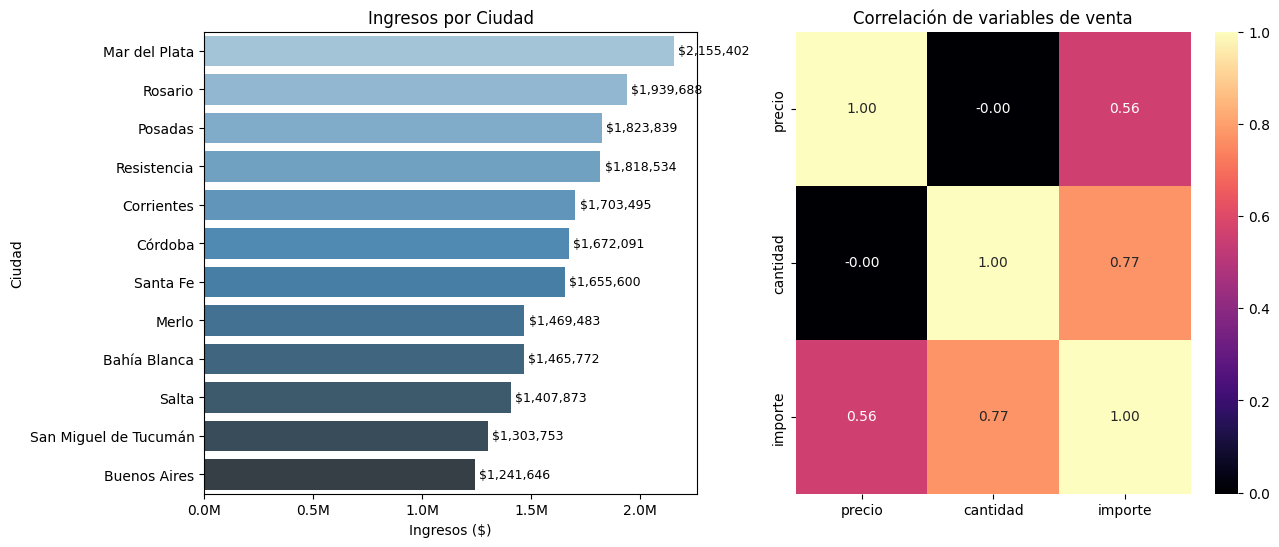

In [142]:
# EDA Análisis Exploratorio de Datos (Seaborn)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px
from plotly.subplots import make_subplots

ingresos_ciudad = (
    df_clientes.
    groupby("ciudad").
    agg(total_ingresos=("ingresos", "sum")).
    sort_values("total_ingresos", ascending=False)
)
ingresos_ciudad = ingresos_ciudad.reset_index()

# ¿Qué ciudades son las mas rentables? Boxplot de ingresos por ciudad 
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.barplot(
    data=ingresos_ciudad,
    x="total_ingresos",
    y="ciudad",
    palette="Blues_d",
    ax=axes[0]
)
axes[0].set_title("Ingresos por Ciudad")
axes[0].set_xlabel("Ingresos ($)")
axes[0].set_ylabel("Ciudad")

# Etiquetas de datos
for container in axes[0].containers: 
    axes[0].bar_label(container,
                 fmt='${:,.0f}', 
                 label_type='edge',
                 padding=3, 
                 fontsize=9)
axes[0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{(x/1_000_000):.1f}M'))

#¿Qué correlación existe entre precio, cantidad e importe?
sns.heatmap(
    df_ventas[["precio","cantidad","importe"]].corr(),
    annot=True,
    cmap="magma",
    fmt=".2f",
    ax=axes[1]
)
plt.title("Correlación de variables de venta")
plt.show()


In [143]:

# barras horizontales Top 10 productos con mayores ingresos
# línea ingresos por mes
# Demografía de clientes por edad con 2 colores por sexo
# Boxplot – Ingresos por ciudad, ciudad mas rentables
# Retorno Inversión por Beneficio
# barra ROI por canal (ROI = ingresos - costo marketing / costo marketing)

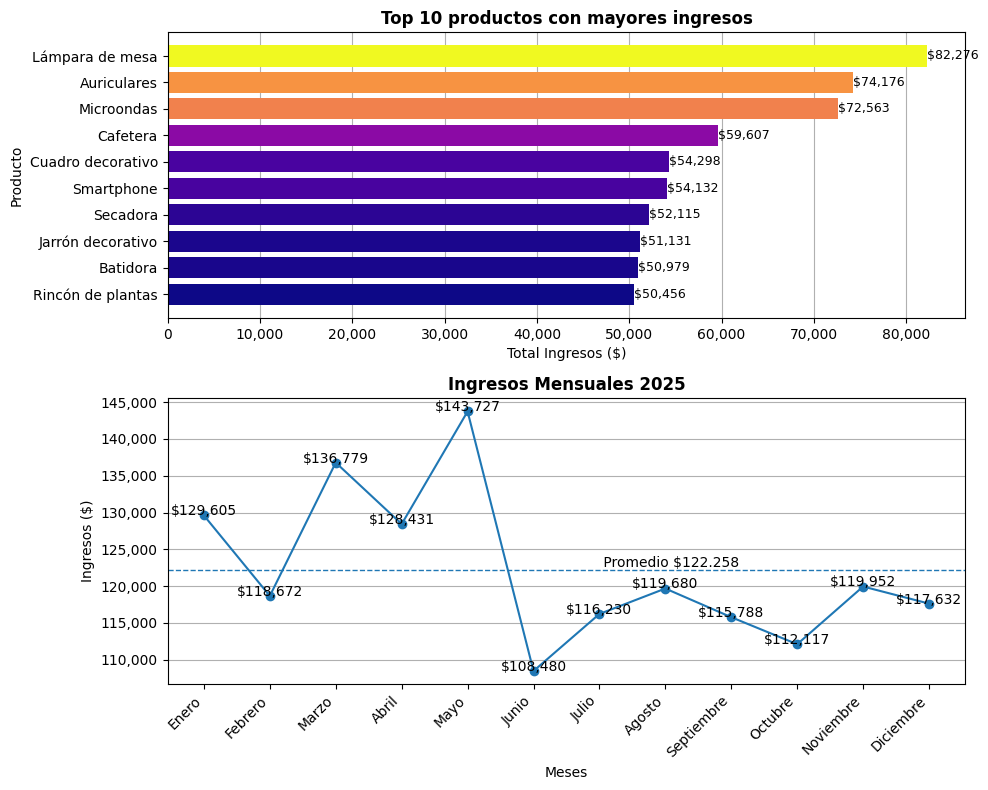

In [144]:
# DASHBOARD FINAL (MATPLOTLIB)
plt.rcParams['axes.axisbelow'] = True #  Queda el grid atrás del gráfico

# Top 10 productos con mayores ingresos
fig, axes = plt.subplots(2, 1, figsize=(10,8))
norm = plt.Normalize(vmin=min(top10_productos["total_ingresos"]), vmax=max(top10_productos["total_ingresos"]))
colors = plt.cm.plasma(norm(top10_productos["total_ingresos"]))

bars = axes[0].barh(top10_productos["producto"], 
                       top10_productos["total_ingresos"], 
                       color=colors)

axes[0].set_title("Top 10 productos con mayores ingresos", fontweight="bold")
axes[0].set_xlabel("Total Ingresos ($)")
axes[0].set_ylabel("Producto")
axes[0].invert_yaxis()

axes[0].grid(True, axis="x")
# Etiquetas de datos
for i, (bar, valor) in enumerate(zip(bars, top10_productos['total_ingresos'])):
    axes[0].text(valor, bar.get_y() + bar.get_height()/2, 
            f'${valor:,.0f}', 
            va='center', ha='left', fontsize=9)
axes[0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1:,.0f}"))


# Ingresos Mensuales
plots = axes[1].plot(ventas_mensuales["mes"],
                       ventas_mensuales["importe"],
                       marker='o',
                       linestyle='-',
                       color='tab:blue')
axes[1].set_title("Ingresos Mensuales 2025", fontweight="bold")
axes[1].set_xlabel("Meses")
axes[1].set_ylabel("Ingresos ($)")

# Etiquetas de datos
for mes, importe in zip(ventas_mensuales["mes"], ventas_mensuales["importe"]):
    axes[1].annotate(
        f"${importe:,.0f}",
        (mes, importe),
        xytext=(0,8), textcoords="offset points", ha="center", va="top")
axes[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1:,.0f}"))
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right")
axes[1].grid(True, axis="y")

# Línea de promedio
promedio = ventas_mensuales["importe"].mean()
axes[1].axhline(promedio, linestyle="--", linewidth=1)
axes[1].text(
    6, promedio,
    f" Promedio ${promedio:,.0f}".replace(",", "."),
    va="bottom")

plt.tight_layout()
plt.show()

In [189]:
# GRÁFICOS INTERACTIVOS (PLOTLY EXPRESS)
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        "Top 10 productos con mayores ingresos",
        "Ingresos por ciudad",
    ),
    specs=[
        [{"type": "bar"}, {"type": "box"}]
    ]
)

# Top 10 productos con mayores ingresos
bar1 = px.bar(
        top10_productos,
        x="total_ingresos",
        y="producto",
        orientation="h",
        text=top10_productos["total_ingresos"].round(0),
        color="total_ingresos",
        color_discrete_sequence=px.colors.sequential.Plasma_r,
        range_color=(top10_productos["total_ingresos"].min(), top10_productos["total_ingresos"].max())
)

fig.add_trace(bar1.data[0], row=1, col=1)
fig.update_yaxes(
    autorange="reversed",
    row=1, col=1
)

fig.update_traces(
    texttemplate='$%{text:,.0f}'
)


# Ingresos por ciudad
box = px.box(
    df_clientes,
    x="ciudad",
    y="ingresos",
    points=False,
    notched=True
)
fig.add_trace(box.data[0], row=1, col=2)

fig.update_yaxes(
    tickformat=".1s",
    title_text="Ingresos por Cliente ($)",
    showgrid=True, 
    gridcolor="lightgrey", 
    dtick=10000, 
    row=1, col=2
)

fig.update_layout(
    title="<b>Análisis Final Interactivo</b>",
    coloraxis_showscale=False,
    plot_bgcolor="white",
    xaxis=dict(showgrid=True, gridcolor="lightgrey", dtick=10000),   
    xaxis_title="Total Ingresos ($)",
    yaxis_title="Producto",
    height=600,
    width=1200
)

# Bordes de cajas
fig.update_traces(
    marker_line_width=1
)
fig.show()
